## Training the original magic wand model
This notebook contains all the Python code needed to train the original magic wand model, recognizing "W", "L", "O" 
gestures.
It is based on code from https://github.com/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050

In [85]:
import csv
import json
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
LABEL_NAME = "gesture"
DATA_NAME = "accel_ms2_xyz"
folders = ["wing", "ring", "slope"]
names = [
    "stefan",
    "patrick",
    "justin",
    "yeongmi",
    "arthur",
    "kai",
    "nico",
    "filip",
    "lukas",
    "peter"
]

In [87]:
def prepare_original_data(folder, name, data, file_to_read):  # pylint: disable=redefined-outer-name
  """Read collected data from files."""
  if os.path.isfile(file_to_read):
    with open(file_to_read, "r") as f:
      lines = csv.reader(f)
      data_new = {}
      data_new[LABEL_NAME] = folder
      data_new[DATA_NAME] = []
      data_new["name"] = name
      for idx, line in enumerate(lines):  # pylint: disable=unused-variable,redefined-outer-name
        if len(line) == 3:
          if line[2] == "-" and data_new[DATA_NAME] or (folder == "negative" and len(data_new[DATA_NAME]) == 120):
            data.append(data_new)
            data_new = {}
            data_new[LABEL_NAME] = folder
            data_new[DATA_NAME] = []
            data_new["name"] = name
          elif line[2] != "-":
            data_new[DATA_NAME].append([float(i) for i in line[0:3]])
      data.append(data_new)

The data from the accelerometer are stored in a folder with filenames of the form:  
output:{gesture}_{name}.txt, where gesture is one of the gestures of the "folder" list above ("wing","ring","slope",or "negative")
and name is one of the list of names.  
Let's try this for one of the files:

In [88]:
folder = "wing"
name = "stefan"
filename = "./data/%s/output_%s_%s.txt" % (folder,folder,name)
print("Filename: ",filename)

Filename:  ./data/wing/output_wing_stefan.txt


The gestures are stored in csv files in which the individual gestures are separated by "-,-,-"  
We read just one of the files:

In [89]:
new_data = []
prepare_original_data(folder,name,new_data,filename)

In [90]:
print("Type of data entry: ",type(new_data), "no of gestures: ",len(new_data))
print(new_data)

Type of data entry:  <class 'list'> no of gestures:  25
[{'gesture': 'wing', 'accel_ms2_xyz': [[-1.47, 8.44, 1.33], [-0.94, 8.04, 1.41], [-0.29, 9.97, 1.93], [-1.58, 8.37, 1.73], [-1.85, 10.41, 1.76], [0.17, 11.01, 2.0], [-0.66, 12.05, 1.9], [0.1, 9.06, 1.75], [-1.96, 4.44, 0.63], [-3.25, 3.14, 0.61], [-2.46, 3.33, 0.26], [-5.67, 1.16, -1.47], [-4.43, 4.68, -3.4], [-1.87, 8.2, -2.8], [-2.97, 17.06, -2.2], [-3.49, 20.18, -2.56], [-5.61, 20.5, -4.17], [0.18, 18.33, -3.75], [2.4, 16.37, -2.61], [-0.45, 6.69, -3.24], [3.97, 10.31, 0.31], [-2.04, -2.56, -1.79], [-4.09, 0.84, 0.46], [2.67, 2.39, 1.76], [-0.89, 0.05, 0.36], [-3.07, 7.3, -1.12], [1.1, 5.92, -0.78], [-0.94, 9.52, -1.75], [-3.44, 15.27, -1.18], [-4.44, 11.23, -2.7], [-3.0, 22.31, -1.45], [-0.92, 12.56, -3.29], [-0.17, 20.25, -1.95], [4.87, 18.23, -4.77], [-2.79, 12.08, -1.62], [4.7, 7.45, -2.94], [-1.78, -4.25, 0.01], [1.92, 0.91, 1.72], [4.1, 5.4, 2.77], [0.86, 5.08, 2.56], [-0.1, 6.6, 2.47], [1.8, 8.88, 3.31], [0.33, 8.66, 3.2

The data are saved in a dictionary with the type of gesture, the data and the name of the person who has executed the
gesture.

Now we read all the gesture data into a list of dictionaries named "data"

In [91]:
data = []
for idx1, folder in enumerate(folders):
  for idx2, name in enumerate(names):
    prepare_original_data(folder, name, data,
                          "./data/%s/output_%s_%s.txt" % (folder, folder, name))
      
print("idx1, idx2: ",idx1,idx2)
print("folders: ",folders,", names: ",names)

n_gestures = len(data)
for idx, name in enumerate(names):
  prepare_original_data("negative", name, data,
                        "./data/negative/output_negative_%s.txt" % (name))
    
n_negative = len(data) - n_gestures
folders.append("negative")

idx1, idx2:  2 9


In [84]:
print("Total number of gestures: ",len(data))
print("Number of gestures: ",n_gestures)
print("Number of negatives: ",n_negative)
print("This is how a gesture looks like:")
print(data[0])

Total number of gestures:  529
Number of gestures:  429
Number of negatives:  100
This is how a gesture looks like:
{'gesture': 'wing', 'accel_ms2_xyz': [[-1.47, 8.44, 1.33], [-0.94, 8.04, 1.41], [-0.29, 9.97, 1.93], [-1.58, 8.37, 1.73], [-1.85, 10.41, 1.76], [0.17, 11.01, 2.0], [-0.66, 12.05, 1.9], [0.1, 9.06, 1.75], [-1.96, 4.44, 0.63], [-3.25, 3.14, 0.61], [-2.46, 3.33, 0.26], [-5.67, 1.16, -1.47], [-4.43, 4.68, -3.4], [-1.87, 8.2, -2.8], [-2.97, 17.06, -2.2], [-3.49, 20.18, -2.56], [-5.61, 20.5, -4.17], [0.18, 18.33, -3.75], [2.4, 16.37, -2.61], [-0.45, 6.69, -3.24], [3.97, 10.31, 0.31], [-2.04, -2.56, -1.79], [-4.09, 0.84, 0.46], [2.67, 2.39, 1.76], [-0.89, 0.05, 0.36], [-3.07, 7.3, -1.12], [1.1, 5.92, -0.78], [-0.94, 9.52, -1.75], [-3.44, 15.27, -1.18], [-4.44, 11.23, -2.7], [-3.0, 22.31, -1.45], [-0.92, 12.56, -3.29], [-0.17, 20.25, -1.95], [4.87, 18.23, -4.77], [-2.79, 12.08, -1.62], [4.7, 7.45, -2.94], [-1.78, -4.25, 0.01], [1.92, 0.91, 1.72], [4.1, 5.4, 2.77], [0.86, 5.08, 2.

Let's find out, how many data sets we have for each gesture

In [61]:
no_of_wings = 0
no_of_rings = 0
no_of_slopes = 0
no_of_negatives = 0
for i in range(len(data)):
    if data[i]["gesture"] == "wing":
        no_of_wings += 1
    elif data[i]["gesture"] == "ring":
        no_of_rings += 1
    elif data[i]["gesture"] == "slope":
        no_of_slopes += 1
    elif data[i]["gesture"] == "negative":
        no_of_negatives += 1
print("No of wings: ",no_of_wings, ", no of rings: ",no_of_rings,", no of slopes: ",no_of_slopes,", no of negatives: ",no_of_negatives)
print("n_gestures: ",n_gestures,", sum: ",no_of_wings+no_of_rings+no_of_slopes)

No of wings:  127 , no of rings:  151 , no of slopes:  151 , no of negatives:  100
n_gestures:  429 , sum:  429


In [62]:
def generate_negative_data(data, number_samples):  # pylint: disable=redefined-outer-name
  """Generate negative data labeled as 'negative6~8'."""
  # Big movement -> around straight line
  for i in range(number_samples//3):
    if i > 80:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative8"}
    elif i > 60:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative7"}
    else:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative6"}
    start_x = (random.random() - 0.5) * 30
    start_y = (random.random() - 0.5) * 30
    start_z = (random.random() - 0.5) * 30
    x_increase = (random.random() - 0.5)
    y_increase = (random.random() - 0.5)
    z_increase = (random.random() - 0.5)
    for j in range(128):
      dic[DATA_NAME].append([
          start_x + j * x_increase + (random.random() - 0.5) * 0.6,
          start_y + j * y_increase + (random.random() - 0.5) * 0.6,
          start_z + j * z_increase + (random.random() - 0.5) * 0.6
      ])
    data.append(dic)
  # Random
  for i in range(number_samples//3):
    if i > 80:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative8"}
    elif i > 60:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative7"}
    else:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative6"}
    for j in range(128):
      dic[DATA_NAME].append([(random.random() - 0.5) * 50,
                             (random.random() - 0.5) * 50,
                             (random.random() - 0.5) * 50])
    data.append(dic)
  # Stay still
  for i in range(number_samples//3):
    if i > 80:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative8"}
    elif i > 60:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative7"}
    else:
      dic = {DATA_NAME: [], LABEL_NAME: "negative", "name": "negative6"}
    start_x = (random.random() - 0.5) * 2
    start_y = (random.random() - 0.5) * 2
    start_z = (random.random() - 0.5) * 2
    for j in range(128):
      dic[DATA_NAME].append([
          start_x + (random.random() - 0.5) * 0.4,
          start_y + (random.random() - 0.5) * 0.4,
          start_z + (random.random() - 0.5) * 0.4
      ])
    data.append(dic)


If there are not enough negative samples, we generate a few more with random numbers

In [63]:
n_negative = len(data) - n_gestures
print("n_negative: ",n_negative)

n_negative:  100


In [64]:
# if there are more than 10% more gesture samples per gesture as negative samples, generate additional negative
# samples
if n_gestures - n_negative * len(folders) > n_gestures/len(folders) * 0.1:
  print("not enough negative samples available, creating random data samples")
  generate_negative_data(data, (math.ceil(n_gestures/len(folders)) - n_negative))
n_negative = len(data) - n_gestures

columns = [LABEL_NAME, "name", DATA_NAME]
df = pd.DataFrame(data, columns=columns)
  
df_gesture_data = pd.DataFrame()
for folder in folders:
  for row in df.loc[df[LABEL_NAME] == folder].iterrows():
    tmp_data = np.array(row[1][DATA_NAME])
    df_tmp = pd.DataFrame({
      "name": np.full(len(tmp_data), row[1]["name"]), 
      LABEL_NAME: np.full(len(tmp_data), folder),
      "t": range(len(tmp_data)),
      "X": tmp_data[:, 0],
      "Y": tmp_data[:, 1],
      "Z": tmp_data[:, 2]
      })
    df_gesture_data = pd.concat([df_gesture_data, df_tmp], ignore_index=True)


not enough negative samples available, creating random data samples


In [65]:
print("gesture_data_length: " + str(n_gestures))
print("negative_data_length: " + str(n_negative))
print("data_length: " + str(len(data)))


gesture_data_length: 429
negative_data_length: 106
data_length: 535


Plot an accelerometer data example for each of the gestures

Write the data in form of a json file

In [66]:
wing_index     = 0
ring_index     = 0
slope_index    = 0
negative_index = 0
gesture_indices = []
while data[wing_index]["gesture"] != "wing":
    wing_index += 1
while data[ring_index]["gesture"] != "ring":
    ring_index += 1
while data[slope_index]["gesture"] != "slope":
    slope_index += 1
while data[negative_index]["gesture"] != "negative":
    negative_index += 1
gesture_indices.append(wing_index)
gesture_indices.append(ring_index)
gesture_indices.append(slope_index)
gesture_indices.append(negative_index)

print("Indices of first wing, ring, slope,negative dataset: {:d}, {:d}, {:d}, {:d}".format(wing_index,
                                                                                           ring_index,
                                                                                           slope_index,
                                                                                           negative_index))
print("Number of gestures: ",len(gesture_indices))

Indices of first wing, ring, slope,negative dataset: 0, 127, 278, 429
4


Plot the gestures

No of values in accelerometer data array:  55
No of values in accelerometer data array:  50
No of values in accelerometer data array:  38
No of values in accelerometer data array:  44


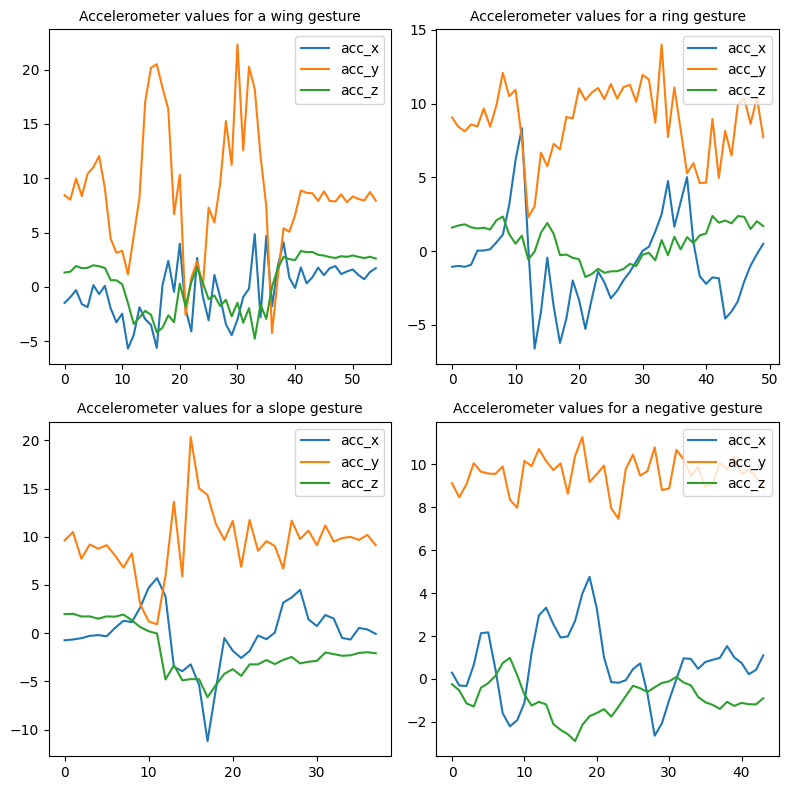

In [109]:
gesture_data = []
for i in range(len(gesture_indices)):
    no_of_values = len(data[gesture_indices[i]]["accel_ms2_xyz"])
    print("No of values in accelerometer data array: ",no_of_values)
    acc = (np.array(data[gesture_indices[i]]["accel_ms2_xyz"])[:,0], 
        np.array(data[gesture_indices[i]]["accel_ms2_xyz"])[:,1], 
        np.array(data[gesture_indices[i]]["accel_ms2_xyz"])[:,2])
    gesture_data.append(acc)
    
fig,axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
for i in range(len(gesture_indices)):
    axs[i//2,i%2].set_title("Accelerometer values for a {:s} gesture".format(data[gesture_indices[i]]["gesture"]),fontsize=10)
    axs[i//2,i%2].plot(gesture_data[i][0],label="acc_x")
    axs[i//2,i%2].plot(gesture_data[i][1],label="acc_y")
    axs[i//2,i%2].plot(gesture_data[i][2],label="acc_z")
    axs[i//2,i%2].legend(loc="upper right")
plt.tight_layout()

In [ ]:
write_data(data, "./data/complete_data")